In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 512)               424448    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 1)                 129       


Total params: 588801 (2.25 MB)


Trainable params: 588801 (2.25 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:27 - loss: 0.1030 - STD: 0.0011 - MAE: 0.3061

 4/80 [>.............................] - ETA: 1s - loss: 0.0369 - STD: 0.0019 - MAE: 0.1488  

 5/80 [>.............................] - ETA: 2s - loss: 0.0339 - STD: 0.0018 - MAE: 0.1422

 6/80 [=>............................] - ETA: 2s - loss: 0.0325 - STD: 0.0016 - MAE: 0.1398

 7/80 [=>............................] - ETA: 2s - loss: 0.0316 - STD: 0.0015 - MAE: 0.1389

 8/80 [==>...........................] - ETA: 3s - loss: 0.0312 - STD: 0.0014 - MAE: 0.1388

 9/80 [==>...........................] - ETA: 3s - loss: 0.0308 - STD: 0.0014 - MAE: 0.1386

10/80 [==>...........................] - ETA: 3s - loss: 0.0304 - STD: 0.0013 - MAE: 0.1384

11/80 [===>..........................] - ETA: 3s - loss: 0.0301 - STD: 0.0012 - MAE: 0.1381

12/80 [===>..........................] - ETA: 3s - loss: 0.0298 - STD: 0.0012 - MAE: 0.1376

13/80 [===>..........................] - ETA: 3s - loss: 0.0294 - STD: 0.0012 - MAE: 0.1366

14/80 [====>.........................] - ETA: 3s - loss: 0.0289 - STD: 0.0011 - MAE: 0.1353

15/80 [====>.........................] - ETA: 3s - loss: 0.0283 - STD: 0.0011 - MAE: 0.1335

16/80 [=====>........................] - ETA: 3s - loss: 0.0276 - STD: 0.0011 - MAE: 0.1314

17/80 [=====>........................] - ETA: 3s - loss: 0.0269 - STD: 0.0011 - MAE: 0.1289

18/80 [=====>........................] - ETA: 3s - loss: 0.0261 - STD: 0.0011 - MAE: 0.1262

19/80 [======>.......................] - ETA: 3s - loss: 0.0252 - STD: 0.0011 - MAE: 0.1235

20/80 [======>.......................] - ETA: 3s - loss: 0.0245 - STD: 0.0011 - MAE: 0.1211

21/80 [======>.......................] - ETA: 3s - loss: 0.0237 - STD: 0.0011 - MAE: 0.1189

22/80 [=======>......................] - ETA: 3s - loss: 0.0231 - STD: 0.0011 - MAE: 0.1172

23/80 [=======>......................] - ETA: 3s - loss: 0.0226 - STD: 0.0011 - MAE: 0.1159

24/80 [========>.....................] - ETA: 2s - loss: 0.0221 - STD: 0.0011 - MAE: 0.1150

25/80 [========>.....................] - ETA: 2s - loss: 0.0218 - STD: 0.0011 - MAE: 0.1143

26/80 [========>.....................] - ETA: 2s - loss: 0.0214 - STD: 0.0011 - MAE: 0.1137

27/80 [=========>....................] - ETA: 3s - loss: 0.0213 - STD: 0.0011 - MAE: 0.1129

31/80 [==========>...................] - ETA: 3s - loss: 0.0198 - STD: 0.0012 - MAE: 0.1091

32/80 [===========>..................] - ETA: 3s - loss: 0.0195 - STD: 0.0012 - MAE: 0.1080

33/80 [===========>..................] - ETA: 2s - loss: 0.0192 - STD: 0.0012 - MAE: 0.1070

34/80 [===========>..................] - ETA: 2s - loss: 0.0189 - STD: 0.0012 - MAE: 0.1060

35/80 [============>.................] - ETA: 2s - loss: 0.0186 - STD: 0.0012 - MAE: 0.1051

36/80 [============>.................] - ETA: 2s - loss: 0.0184 - STD: 0.0012 - MAE: 0.1042

37/80 [============>.................] - ETA: 2s - loss: 0.0181 - STD: 0.0012 - MAE: 0.1034

38/80 [=============>................] - ETA: 2s - loss: 0.0179 - STD: 0.0012 - MAE: 0.1026

39/80 [=============>................] - ETA: 2s - loss: 0.0177 - STD: 0.0012 - MAE: 0.1019

40/80 [==============>...............] - ETA: 2s - loss: 0.0175 - STD: 0.0012 - MAE: 0.1012

41/80 [==============>...............] - ETA: 2s - loss: 0.0173 - STD: 0.0013 - MAE: 0.1005

42/80 [==============>...............] - ETA: 2s - loss: 0.0171 - STD: 0.0013 - MAE: 0.0999

43/80 [===============>..............] - ETA: 2s - loss: 0.0170 - STD: 0.0013 - MAE: 0.0993

44/80 [===============>..............] - ETA: 2s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0987

45/80 [===============>..............] - ETA: 2s - loss: 0.0166 - STD: 0.0013 - MAE: 0.0982

46/80 [================>.............] - ETA: 2s - loss: 0.0164 - STD: 0.0014 - MAE: 0.0977

47/80 [================>.............] - ETA: 2s - loss: 0.0163 - STD: 0.0014 - MAE: 0.0972

48/80 [=================>............] - ETA: 1s - loss: 0.0161 - STD: 0.0014 - MAE: 0.0968

49/80 [=================>............] - ETA: 1s - loss: 0.0160 - STD: 0.0014 - MAE: 0.0965

50/80 [=================>............] - ETA: 1s - loss: 0.0159 - STD: 0.0014 - MAE: 0.0961

51/80 [==================>...........] - ETA: 1s - loss: 0.0157 - STD: 0.0015 - MAE: 0.0957

52/80 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 0.0015 - MAE: 0.0954

53/80 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 0.0015 - MAE: 0.0950

54/80 [===================>..........] - ETA: 1s - loss: 0.0153 - STD: 0.0015 - MAE: 0.0947

55/80 [===================>..........] - ETA: 1s - loss: 0.0152 - STD: 0.0016 - MAE: 0.0943

56/80 [====================>.........] - ETA: 1s - loss: 0.0151 - STD: 0.0016 - MAE: 0.0940

57/80 [====================>.........] - ETA: 1s - loss: 0.0150 - STD: 0.0016 - MAE: 0.0936

58/80 [====================>.........] - ETA: 1s - loss: 0.0149 - STD: 0.0016 - MAE: 0.0933

59/80 [=====================>........] - ETA: 1s - loss: 0.0148 - STD: 0.0017 - MAE: 0.0929

60/80 [=====================>........] - ETA: 1s - loss: 0.0147 - STD: 0.0017 - MAE: 0.0926

61/80 [=====================>........] - ETA: 1s - loss: 0.0146 - STD: 0.0017 - MAE: 0.0923

62/80 [======================>.......] - ETA: 1s - loss: 0.0145 - STD: 0.0017 - MAE: 0.0920

63/80 [======================>.......] - ETA: 1s - loss: 0.0144 - STD: 0.0018 - MAE: 0.0917

64/80 [=======================>......] - ETA: 0s - loss: 0.0143 - STD: 0.0018 - MAE: 0.0914

65/80 [=======================>......] - ETA: 0s - loss: 0.0143 - STD: 0.0018 - MAE: 0.0911

66/80 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 0.0019 - MAE: 0.0908

67/80 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.0019 - MAE: 0.0906

68/80 [========================>.....] - ETA: 0s - loss: 0.0140 - STD: 0.0019 - MAE: 0.0904

69/80 [========================>.....] - ETA: 0s - loss: 0.0139 - STD: 0.0020 - MAE: 0.0901

70/80 [=========================>....] - ETA: 0s - loss: 0.0139 - STD: 0.0020 - MAE: 0.0899

71/80 [=========================>....] - ETA: 0s - loss: 0.0138 - STD: 0.0020 - MAE: 0.0897

72/80 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0895

73/80 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0893

74/80 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0021 - MAE: 0.0891

75/80 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.0022 - MAE: 0.0889

76/80 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.0022 - MAE: 0.0887

77/80 [===========================>..] - ETA: 0s - loss: 0.0134 - STD: 0.0023 - MAE: 0.0885

78/80 [============================>.] - ETA: 0s - loss: 0.0133 - STD: 0.0023 - MAE: 0.0883

79/80 [============================>.] - ETA: 0s - loss: 0.0133 - STD: 0.0024 - MAE: 0.0882

80/80 [==============================] - ETA: 0s - loss: 0.0132 - STD: 0.0024 - MAE: 0.0880

80/80 [==============================] - 7s 70ms/step - loss: 0.0132 - STD: 0.0024 - MAE: 0.0880 - val_loss: 0.0081 - val_STD: 0.0043 - val_MAE: 0.0695


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0090 - STD: 0.0063 - MAE: 0.0743

 2/80 [..............................] - ETA: 4s - loss: 0.0088 - STD: 0.0064 - MAE: 0.0735

 3/80 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0732

 4/80 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0731

 5/80 [>.............................] - ETA: 4s - loss: 0.0086 - STD: 0.0067 - MAE: 0.0729

 6/80 [=>............................] - ETA: 4s - loss: 0.0086 - STD: 0.0069 - MAE: 0.0729

 7/80 [=>............................] - ETA: 4s - loss: 0.0086 - STD: 0.0070 - MAE: 0.0731

 8/80 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.0071 - MAE: 0.0730

 9/80 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.0073 - MAE: 0.0730

10/80 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0731

11/80 [===>..........................] - ETA: 4s - loss: 0.0086 - STD: 0.0075 - MAE: 0.0732

12/80 [===>..........................] - ETA: 3s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0731

13/80 [===>..........................] - ETA: 3s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0731

14/80 [====>.........................] - ETA: 3s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0731

15/80 [====>.........................] - ETA: 3s - loss: 0.0086 - STD: 0.0081 - MAE: 0.0731

16/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0083 - MAE: 0.0730

17/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0730

18/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0731

19/80 [======>.......................] - ETA: 3s - loss: 0.0086 - STD: 0.0087 - MAE: 0.0730

20/80 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0089 - MAE: 0.0730

21/80 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0091 - MAE: 0.0729

22/80 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0728

23/80 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0094 - MAE: 0.0728

24/80 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0096 - MAE: 0.0728

25/80 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0098 - MAE: 0.0727

26/80 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0100 - MAE: 0.0727

27/80 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0102 - MAE: 0.0726

28/80 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0104 - MAE: 0.0726

29/80 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0106 - MAE: 0.0726

30/80 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0108 - MAE: 0.0725

31/80 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0110 - MAE: 0.0725

32/80 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0112 - MAE: 0.0724

33/80 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0114 - MAE: 0.0724

34/80 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0117 - MAE: 0.0723

35/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0119 - MAE: 0.0722

36/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0121 - MAE: 0.0722

37/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0123 - MAE: 0.0721

38/80 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.0126 - MAE: 0.0721

39/80 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.0128 - MAE: 0.0720

40/80 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.0131 - MAE: 0.0720

41/80 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0719

42/80 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0135 - MAE: 0.0719

43/80 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0138 - MAE: 0.0718

44/80 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0140 - MAE: 0.0718

45/80 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0143 - MAE: 0.0717

46/80 [================>.............] - ETA: 1s - loss: 0.0082 - STD: 0.0146 - MAE: 0.0717

47/80 [================>.............] - ETA: 1s - loss: 0.0082 - STD: 0.0148 - MAE: 0.0716

48/80 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.0151 - MAE: 0.0716

49/80 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.0153 - MAE: 0.0715

50/80 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0156 - MAE: 0.0715

51/80 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0159 - MAE: 0.0714

52/80 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0161 - MAE: 0.0714

53/80 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0164 - MAE: 0.0713

54/80 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.0167 - MAE: 0.0713

55/80 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.0169 - MAE: 0.0712

56/80 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0172 - MAE: 0.0712

57/80 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0175 - MAE: 0.0711

58/80 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0177 - MAE: 0.0711

59/80 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0180 - MAE: 0.0710

60/80 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0183 - MAE: 0.0710

61/80 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0186 - MAE: 0.0709

62/80 [======================>.......] - ETA: 1s - loss: 0.0080 - STD: 0.0188 - MAE: 0.0709

64/80 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0193 - MAE: 0.0708

65/80 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0196 - MAE: 0.0707

66/80 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0198 - MAE: 0.0707

67/80 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0201 - MAE: 0.0706

68/80 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0203 - MAE: 0.0706

69/80 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0206 - MAE: 0.0705

70/80 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0208 - MAE: 0.0705

71/80 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0211 - MAE: 0.0704

72/80 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0213 - MAE: 0.0704

73/80 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0215 - MAE: 0.0703

74/80 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0218 - MAE: 0.0703

75/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0220 - MAE: 0.0702

76/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0222 - MAE: 0.0702

77/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0224 - MAE: 0.0701

78/80 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0226 - MAE: 0.0701

79/80 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0229 - MAE: 0.0701

80/80 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0231 - MAE: 0.0700

80/80 [==============================] - 5s 61ms/step - loss: 0.0078 - STD: 0.0231 - MAE: 0.0700 - val_loss: 0.0066 - val_STD: 0.0262 - val_MAE: 0.0617


Epoch 3/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0072 - STD: 0.0401 - MAE: 0.0668

 2/80 [..............................] - ETA: 5s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0665

 3/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0665

 4/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0664

 5/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0665

 6/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0664

 7/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0664

 8/80 [==>...........................] - ETA: 4s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0663

 9/80 [==>...........................] - ETA: 4s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0663

10/80 [==>...........................] - ETA: 3s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0663

11/80 [===>..........................] - ETA: 3s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0662

12/80 [===>..........................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0661

13/80 [===>..........................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0661

14/80 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0661

15/80 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0660

16/80 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0660

17/80 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0659

18/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0406 - MAE: 0.0660

19/80 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0660

20/80 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0659

21/80 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0659

22/80 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0407 - MAE: 0.0659

24/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0658

25/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0409 - MAE: 0.0658

26/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0409 - MAE: 0.0658

27/80 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0410 - MAE: 0.0657

28/80 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0410 - MAE: 0.0657

29/80 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0410 - MAE: 0.0657

30/80 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0411 - MAE: 0.0657

31/80 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0657

32/80 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0657

33/80 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0657

34/80 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0413 - MAE: 0.0656

35/80 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0413 - MAE: 0.0656

36/80 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0656

37/80 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0656

38/80 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0656

39/80 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0655

40/80 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0655

41/80 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0655

42/80 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0655

43/80 [===============>..............] - ETA: 2s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0655

44/80 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0655

45/80 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0654

46/80 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0654

47/80 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0653

48/80 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0653

49/80 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0653

50/80 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0653

51/80 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0652

52/80 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0652

53/80 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0651

54/80 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0651

55/80 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0650

56/80 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0650

57/80 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0650

58/80 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0423 - MAE: 0.0650

59/80 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0423 - MAE: 0.0649

60/80 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0649

61/80 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0649

62/80 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0648

63/80 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0648

64/80 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0425 - MAE: 0.0648

65/80 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0425 - MAE: 0.0647

66/80 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0425 - MAE: 0.0647

67/80 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0426 - MAE: 0.0647

68/80 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0426 - MAE: 0.0647

69/80 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0426 - MAE: 0.0646

70/80 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0427 - MAE: 0.0646

71/80 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0427 - MAE: 0.0646

72/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0427 - MAE: 0.0645

73/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0428 - MAE: 0.0645

74/80 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0428 - MAE: 0.0645

75/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0429 - MAE: 0.0644

76/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0429 - MAE: 0.0644

77/80 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0430 - MAE: 0.0643

78/80 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0430 - MAE: 0.0643

79/80 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0643

80/80 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0431 - MAE: 0.0642

80/80 [==============================] - 5s 58ms/step - loss: 0.0068 - STD: 0.0431 - MAE: 0.0642 - val_loss: 0.0057 - val_STD: 0.0300 - val_MAE: 0.0562


Epoch 4/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0062 - STD: 0.0468 - MAE: 0.0612

 2/80 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0473 - MAE: 0.0610

 3/80 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0612

 4/80 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0612

 5/80 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0611

 6/80 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0610

 7/80 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0473 - MAE: 0.0609

 8/80 [==>...........................] - ETA: 4s - loss: 0.0062 - STD: 0.0474 - MAE: 0.0609

 9/80 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0475 - MAE: 0.0609

10/80 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0608

11/80 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0607

12/80 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0606

13/80 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0604

14/80 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0603

15/80 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0477 - MAE: 0.0603

16/80 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0478 - MAE: 0.0603

17/80 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0479 - MAE: 0.0602

18/80 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0480 - MAE: 0.0602

19/80 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0480 - MAE: 0.0601

20/80 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0481 - MAE: 0.0601

21/80 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0482 - MAE: 0.0600

22/80 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0484 - MAE: 0.0600

23/80 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0485 - MAE: 0.0600

24/80 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.0485 - MAE: 0.0599

25/80 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.0486 - MAE: 0.0598

26/80 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.0487 - MAE: 0.0598

27/80 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.0488 - MAE: 0.0598

28/80 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.0489 - MAE: 0.0598

29/80 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.0491 - MAE: 0.0597

30/80 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0492 - MAE: 0.0596

31/80 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0493 - MAE: 0.0596

32/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0494 - MAE: 0.0595

33/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0496 - MAE: 0.0595

34/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0497 - MAE: 0.0595

35/80 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0498 - MAE: 0.0594

36/80 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0499 - MAE: 0.0593

37/80 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0501 - MAE: 0.0592

38/80 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0502 - MAE: 0.0592

39/80 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0504 - MAE: 0.0591

40/80 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0505 - MAE: 0.0591

41/80 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0506 - MAE: 0.0590

42/80 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.0507 - MAE: 0.0590

43/80 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.0508 - MAE: 0.0590

44/80 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0509 - MAE: 0.0589

45/80 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0510 - MAE: 0.0589

46/80 [================>.............] - ETA: 2s - loss: 0.0058 - STD: 0.0511 - MAE: 0.0588

47/80 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0512 - MAE: 0.0587

48/80 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0513 - MAE: 0.0587

49/80 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0514 - MAE: 0.0586

50/80 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0515 - MAE: 0.0586

51/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0515 - MAE: 0.0585

52/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0516 - MAE: 0.0585

53/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0585

54/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0584

55/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0519 - MAE: 0.0584

56/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0583

57/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0583

58/80 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0522 - MAE: 0.0583

59/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0523 - MAE: 0.0582

60/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0524 - MAE: 0.0582

62/80 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0581

63/80 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0527 - MAE: 0.0580

64/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0528 - MAE: 0.0580

65/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0579

66/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0579

67/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0579

68/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0578

69/80 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0578

70/80 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0577

71/80 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0534 - MAE: 0.0577

72/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0577

73/80 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0535 - MAE: 0.0576

74/80 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0536 - MAE: 0.0575

75/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0537 - MAE: 0.0575

76/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0575

77/80 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0574

78/80 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0539 - MAE: 0.0574

79/80 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0540 - MAE: 0.0574

80/80 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0573

80/80 [==============================] - 5s 62ms/step - loss: 0.0056 - STD: 0.0541 - MAE: 0.0573 - val_loss: 0.0046 - val_STD: 0.0445 - val_MAE: 0.0504


Epoch 5/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0548

 2/80 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0542

 3/80 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0545

 4/80 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0545

 5/80 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0545

 6/80 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0544

 7/80 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0543

 8/80 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

 9/80 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0542

10/80 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0542

11/80 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0541

13/80 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0541

14/80 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0541

15/80 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0540

16/80 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0539

17/80 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0540

18/80 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0539

19/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0538

20/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0538

21/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0538

22/80 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0537

23/80 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0536

24/80 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0536

25/80 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0536

26/80 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0605 - MAE: 0.0536

27/80 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0605 - MAE: 0.0535

28/80 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0535

29/80 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0535

30/80 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0534

31/80 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0534

32/80 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0534

33/80 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0534

34/80 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0534

35/80 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0534

36/80 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0609 - MAE: 0.0533

37/80 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0609 - MAE: 0.0533

38/80 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0609 - MAE: 0.0533

39/80 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0610 - MAE: 0.0532

40/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0611 - MAE: 0.0532

41/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0611 - MAE: 0.0532

42/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0611 - MAE: 0.0531

43/80 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0531

44/80 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0531

45/80 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0530

46/80 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0530

47/80 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0530

48/80 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0614 - MAE: 0.0529

49/80 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0614 - MAE: 0.0529

50/80 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0614 - MAE: 0.0529

51/80 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0528

52/80 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0528

53/80 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0528

54/80 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0528

55/80 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0527

56/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0617 - MAE: 0.0527

57/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0527

58/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0526

59/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0618 - MAE: 0.0526

60/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0619 - MAE: 0.0526

61/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0619 - MAE: 0.0525

62/80 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0525

63/80 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0525

64/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0525

65/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0621 - MAE: 0.0524

66/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0621 - MAE: 0.0524

67/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0524

68/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0524

69/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0523

70/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0623 - MAE: 0.0523

71/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0623 - MAE: 0.0523

72/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0523

73/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0522

74/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0522

75/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0522

76/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0625 - MAE: 0.0522

77/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0521

78/80 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0521

79/80 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0521

80/80 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0627 - MAE: 0.0520

80/80 [==============================] - 5s 60ms/step - loss: 0.0047 - STD: 0.0627 - MAE: 0.0520 - val_loss: 0.0040 - val_STD: 0.0531 - val_MAE: 0.0468


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0499

 2/80 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0498

 3/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0501

 4/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0500

 5/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0499

 6/80 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0498

 7/80 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

 8/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0498

 9/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0497

10/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

11/80 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0499

12/80 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0499

13/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0500

14/80 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0499

15/80 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0499

17/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

18/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0499

19/80 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

20/80 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499

21/80 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0499

22/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0498

23/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0498

24/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0498

25/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

26/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

27/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

28/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0497

29/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0497

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0497

31/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0497

32/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0496

33/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0496

34/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0496

35/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0496

36/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0496

37/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0496

38/80 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0496

39/80 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0495

40/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0496

41/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0496

42/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

43/80 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0496

44/80 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

45/80 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

46/80 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0496

47/80 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

48/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

49/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

50/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

51/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

52/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

53/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0495

54/80 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

55/80 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0495

56/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0495

57/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0495

58/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0495

59/80 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0495

60/80 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0495

61/80 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0494

62/80 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0494

63/80 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0494

64/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0494

65/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

66/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0494

67/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

68/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

69/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

70/80 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

71/80 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

72/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

73/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

74/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

75/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

76/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

77/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

78/80 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

79/80 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

80/80 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

80/80 [==============================] - 5s 62ms/step - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492 - val_loss: 0.0039 - val_STD: 0.0560 - val_MAE: 0.0451


Epoch 7/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0478

 2/80 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0479

 3/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

 4/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

 5/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

 6/80 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

 7/80 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0484

 8/80 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0482

 9/80 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0482

10/80 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0483

11/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0482

12/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0481

13/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0481

14/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0481

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0481

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0480

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

22/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0480

23/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

25/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

26/80 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

27/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

28/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

29/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

30/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

31/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0479

32/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

33/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

34/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

35/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

36/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

37/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

38/80 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

39/80 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

40/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

41/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

42/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

43/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

44/80 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

45/80 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0476

46/80 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

47/80 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

48/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

49/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0476

50/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

51/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

52/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

53/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

54/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

55/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0476

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

62/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

77/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

79/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

80/80 [==============================] - 5s 58ms/step - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475 - val_loss: 0.0036 - val_STD: 0.0582 - val_MAE: 0.0440


Epoch 8/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0697 - MAE: 0.0463

 2/80 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

 3/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0466

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0468

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0471

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0471

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0471

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0472

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0471

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

11/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

12/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0470

14/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

15/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0470

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0470

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0470

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0470

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

21/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0470

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0470

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0469

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0470

28/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0469

29/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0469

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0469

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0469

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0469

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

41/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

42/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

60/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

61/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

62/80 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

63/80 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

64/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

65/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

66/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

67/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

68/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

69/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

70/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

71/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

72/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0469

74/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

75/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0469

77/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

78/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

79/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

80/80 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

80/80 [==============================] - 5s 60ms/step - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469 - val_loss: 0.0035 - val_STD: 0.0637 - val_MAE: 0.0453


Epoch 9/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0487

 2/80 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0478

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0471

 4/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0476

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

11/80 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

12/80 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

20/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

21/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

22/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

23/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

24/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

25/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

26/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

27/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

28/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

41/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

42/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

80/80 [==============================] - 5s 60ms/step - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462 - val_loss: 0.0034 - val_STD: 0.0615 - val_MAE: 0.0429


Epoch 10/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0461

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

 5/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

 6/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

 8/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

 9/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

10/80 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

11/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

18/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

19/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

25/80 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

26/80 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

27/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

28/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

43/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

44/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

45/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

46/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

62/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

80/80 [==============================] - 5s 56ms/step - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0591 - val_MAE: 0.0431


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0449

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0450

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0452

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0453

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

26/80 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

27/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

44/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

45/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

62/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

80/80 [==============================] - 5s 57ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0627 - val_MAE: 0.0423


Epoch 12/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

27/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

45/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

80/80 [==============================] - 5s 60ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451 - val_loss: 0.0033 - val_STD: 0.0603 - val_MAE: 0.0418


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0713 - MAE: 0.0451

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0460

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0452

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

28/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

29/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

80/80 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447 - val_loss: 0.0032 - val_STD: 0.0628 - val_MAE: 0.0415


Epoch 14/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0725 - MAE: 0.0436

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0443

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0451

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0450

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

80/80 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445 - val_loss: 0.0031 - val_STD: 0.0628 - val_MAE: 0.0412


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0435

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0438

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

80/80 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442 - val_loss: 0.0031 - val_STD: 0.0652 - val_MAE: 0.0418


Epoch 16/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0457

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444

 6/80 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

 7/80 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 8/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

 9/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

80/80 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0609 - val_MAE: 0.0411


Epoch 17/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0434

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0445

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0442

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0443

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

80/80 [==============================] - 5s 60ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0583 - val_MAE: 0.0425


Epoch 18/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0706 - MAE: 0.0446

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0455

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

13/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

80/80 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0403


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0434

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0448

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0461

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0467

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0467

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0471

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0472

45/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0475

46/80 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0475

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0479

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

51/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0482

52/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0484

53/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0483

54/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0723 - MAE: 0.0484

55/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0483

56/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0484

57/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0485

58/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

59/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0484

60/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0483

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0484

62/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0484

63/80 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0483

64/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0483

65/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0482

66/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0482

67/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0482

68/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0481

69/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0481

70/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0480

71/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0480

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0480

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0478

77/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0478

78/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0477

79/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0477

80/80 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0476

80/80 [==============================] - 5s 59ms/step - loss: 0.0041 - STD: 0.0716 - MAE: 0.0476 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0413


Epoch 20/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0445

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0445

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0440

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0725 - MAE: 0.0437

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0725 - MAE: 0.0437

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0732 - MAE: 0.0437

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0440

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0439

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0438

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0438

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0438

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0437

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0736 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0435

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0435

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0435

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0435

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0435

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0434

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0434

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0434

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

80/80 [==============================] - 5s 60ms/step - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0402


Epoch 21/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0433

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0431

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

29/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

80/80 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0607 - val_MAE: 0.0406


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0425

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0429

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0432

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

80/80 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0400


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0431

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0428

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

80/80 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427 - val_loss: 0.0030 - val_STD: 0.0647 - val_MAE: 0.0401


Epoch 24/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0427

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

 8/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

80/80 [==============================] - 5s 59ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0639 - val_MAE: 0.0396


Epoch 25/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

 2/80 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0425

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0396


Epoch 26/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0397


Epoch 27/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0427

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0422

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

80/80 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424 - val_loss: 0.0032 - val_STD: 0.0692 - val_MAE: 0.0434


Epoch 28/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0465

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0462

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0447

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0456

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0462

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0455

 7/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0469

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0474

10/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0499

11/80 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0511

12/80 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0518

13/80 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0729 - MAE: 0.0523

14/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0733 - MAE: 0.0521

15/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0521

16/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0519

17/80 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0719 - MAE: 0.0520

18/80 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0518

19/80 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0515

20/80 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512

21/80 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0510

22/80 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0510

23/80 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

24/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0505

25/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0502

26/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0502

27/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0499

28/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0497

29/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0495

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0494

31/80 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0493

32/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

33/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0489

34/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0487

35/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0486

36/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0485

37/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0483

38/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0482

39/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0481

40/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0480

41/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0478

42/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0477

43/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0476

44/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0476

45/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0475

46/80 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0470

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0470

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0469

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0468

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0463

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0462

60/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0462

61/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0461

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0456

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0456

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0455

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0455

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0454

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

80/80 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0394


Epoch 29/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0392


Epoch 30/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0393


Epoch 31/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0390


Epoch 32/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0422

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0422

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

80/80 [==============================] - 5s 59ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0665 - val_MAE: 0.0402


Epoch 33/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0436

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0428

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

80/80 [==============================] - 5s 59ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0631 - val_MAE: 0.0389


Epoch 34/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0420

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424 - val_loss: 0.0039 - val_STD: 0.0710 - val_MAE: 0.0500


Epoch 35/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0531

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0471

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0461

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0453

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0457

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0451

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0448

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0446

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0429

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0428

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0428

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0428

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0428

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0428

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0390


Epoch 36/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0670 - val_MAE: 0.0398


Epoch 37/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0421

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0386


Epoch 38/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0409

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0385


Epoch 39/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0411

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0386


Epoch 40/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0387


Epoch 41/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0404

 2/80 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413 - val_loss: 0.0032 - val_STD: 0.0703 - val_MAE: 0.0431


Epoch 42/10000


 1/80 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0850 - MAE: 0.0460

 2/80 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0442

 3/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0432

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0435

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0434

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0433

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0433

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0434

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0433

13/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0433

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0433

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0432

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0433

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0434

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0434

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0440

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

27/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0461

28/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

29/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0463

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0464

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0463

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0466

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0464

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0464

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0463

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0462

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0462

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0461

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0461

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0460

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0459

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0458

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

45/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0457

46/80 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0455

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0455

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0454

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0453

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0452

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0451

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0449

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0448

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

63/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0443

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0443

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0442

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

80/80 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438 - val_loss: 0.0028 - val_STD: 0.0641 - val_MAE: 0.0385


Epoch 43/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0383


Epoch 44/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0383


Epoch 45/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0384


Epoch 46/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0758 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0406

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0665 - val_MAE: 0.0383


Epoch 47/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0813 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0407

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0406

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0408

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0407

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0408

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0654 - val_MAE: 0.0382


Epoch 48/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0401

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0406

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0381


Epoch 49/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 7/80 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0027 - val_STD: 0.0672 - val_MAE: 0.0383


Epoch 50/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0820 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0402

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0403

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0405

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0381


Epoch 51/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0674 - val_MAE: 0.0389


Epoch 52/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0804 - MAE: 0.0410

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0385


Epoch 53/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0806 - MAE: 0.0413

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0409

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0408

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0407

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

62/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

80/80 [==============================] - 5s 58ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0388


Epoch 54/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0748 - MAE: 0.0404

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0403

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402 - val_loss: 0.0027 - val_STD: 0.0656 - val_MAE: 0.0377


Epoch 55/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406 - val_loss: 0.0027 - val_STD: 0.0658 - val_MAE: 0.0378


Epoch 56/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0642 - val_MAE: 0.0378


Epoch 57/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0397

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0381


Epoch 58/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0398

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0376


Epoch 59/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

 6/80 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

 7/80 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

24/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0378


Epoch 60/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0397

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0636 - val_MAE: 0.0377


Epoch 61/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0776 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0778 - MAE: 0.0394

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0376


Epoch 62/10000


 1/80 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0396

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0027 - val_STD: 0.0676 - val_MAE: 0.0380


Epoch 63/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0815 - MAE: 0.0395

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0394

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0400

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0401

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401 - val_loss: 0.0027 - val_STD: 0.0657 - val_MAE: 0.0375


Epoch 64/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0374


Epoch 65/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398 - val_loss: 0.0027 - val_STD: 0.0667 - val_MAE: 0.0375


Epoch 66/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0813 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0393

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399 - val_loss: 0.0027 - val_STD: 0.0651 - val_MAE: 0.0374


Epoch 67/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0392

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0391

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0393

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0654 - val_MAE: 0.0373


Epoch 68/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0391

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0635 - val_MAE: 0.0377


Epoch 69/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

30/80 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

46/80 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

63/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0373


Epoch 70/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0390

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0376


Epoch 71/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0391

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398 - val_loss: 0.0027 - val_STD: 0.0646 - val_MAE: 0.0374


Epoch 72/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0679 - val_MAE: 0.0379


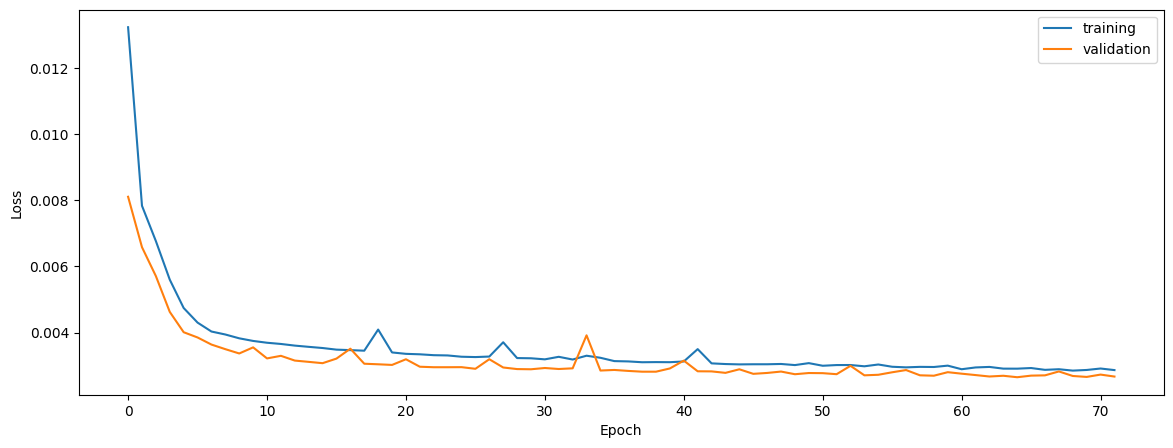

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8315095001546674
0.831474730740904
0.8149897320130772


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8322585924299021
0.8462569648177137
0.82467978961578


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.831326148309231
0.8429774822059489
0.8219190564566365


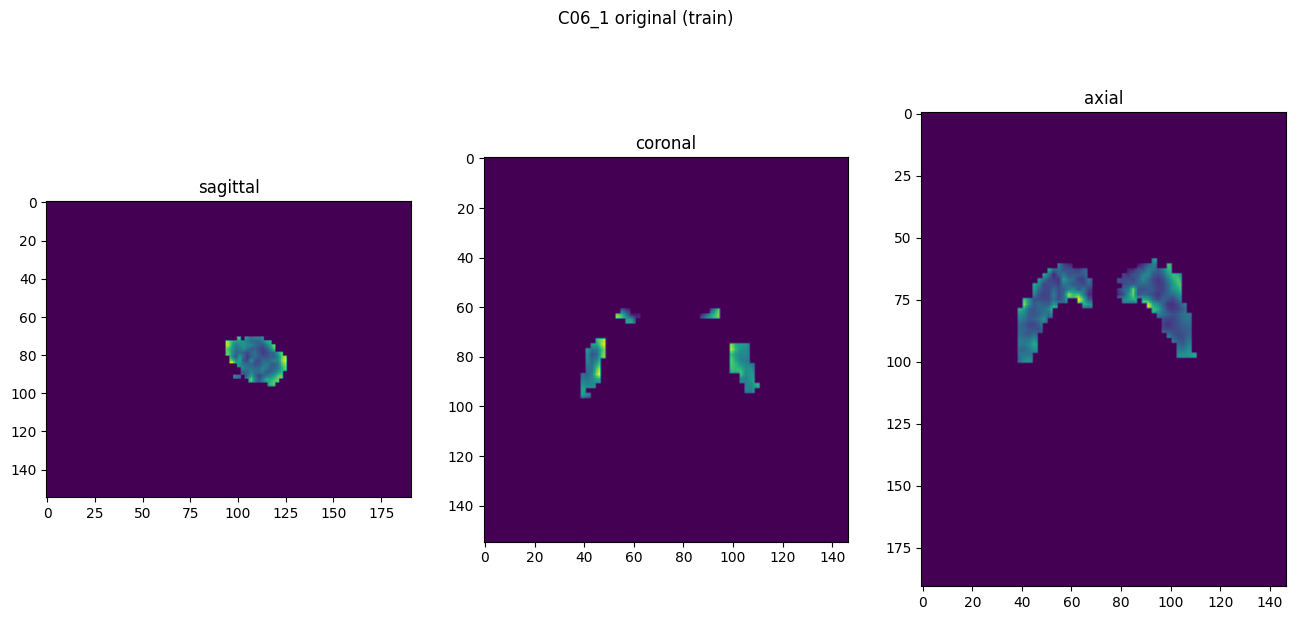

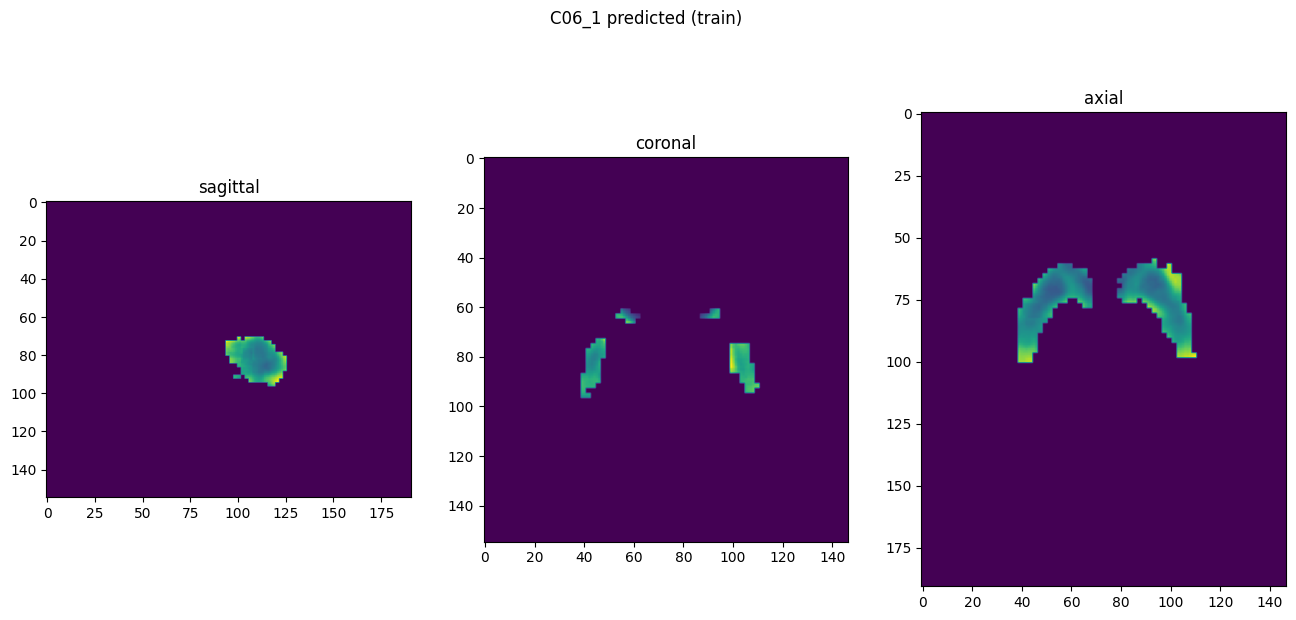

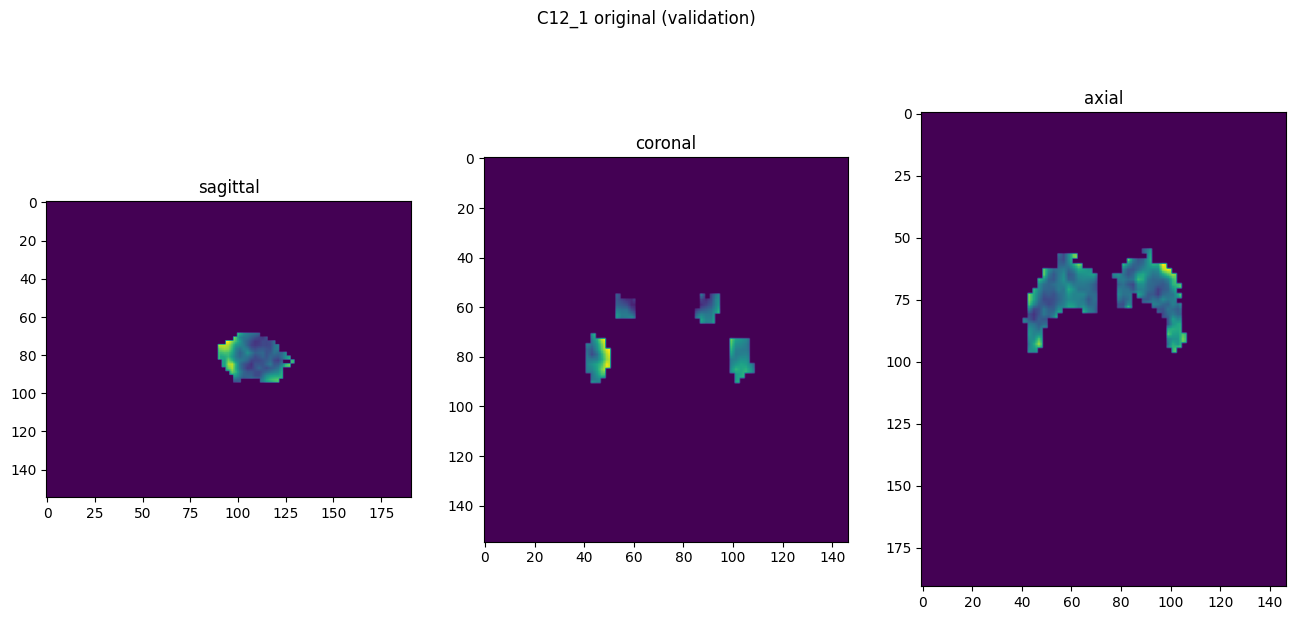

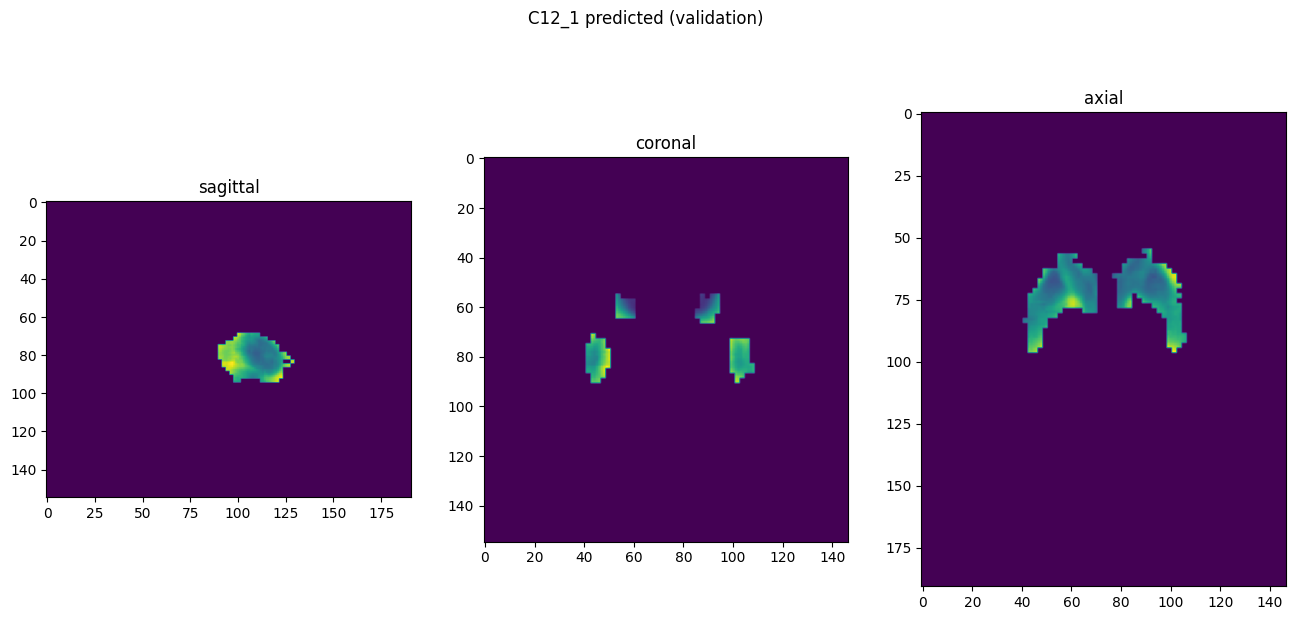

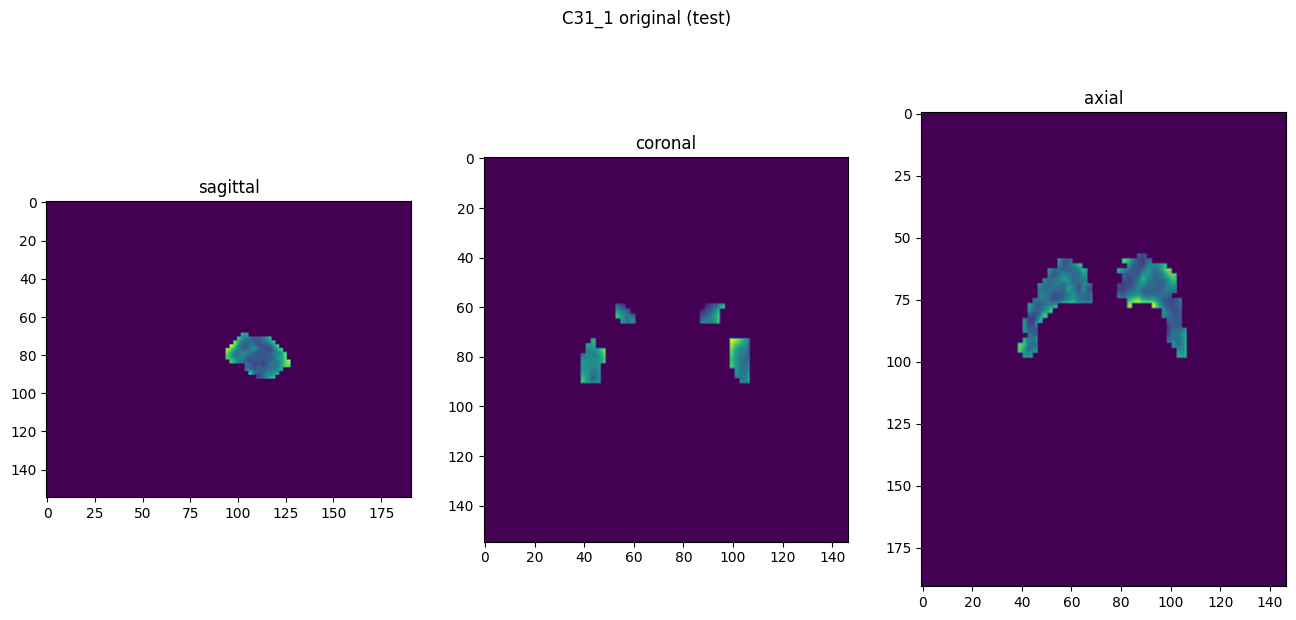

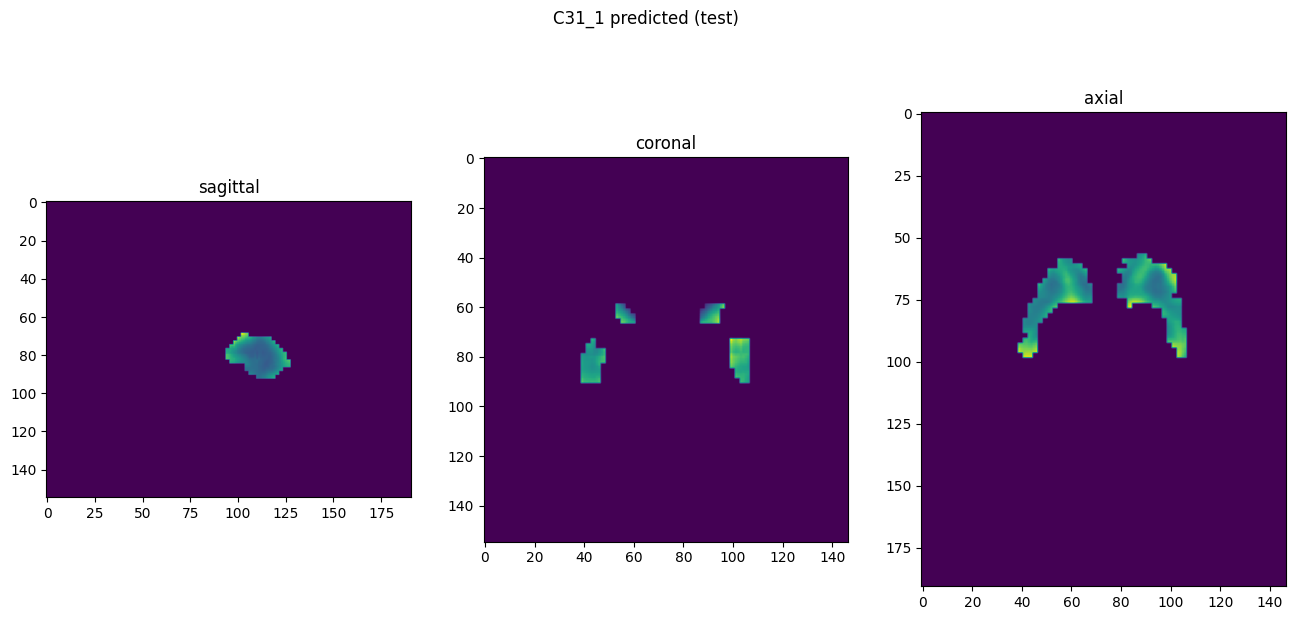

In [10]:
showResults(model, gen, threshold=None, background=False)